# Data Profiling, Cleaning & EDA-Sierraleone
**Objective:** Profile, clean, and explore the solar dataset for Sierraleone so it’s ready for comparison and region-ranking tasks.

This notebook includes:
- Summary statistics and missing-value report
- Outlier detection and cleaning
- Time series analysis
- Correlation and scatter plots
- Wind and temperature analysis
- Bubble charts

## Importing the dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Loading the Data

In [ ]:
# Set both plotting and display settings
import pandas as pd

# Load dataset
df = pd.read_csv(r"D:\Python\Week_01\data\data\sierraleone-bumbuna.csv")

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 10)

In [ ]:
# Show basic info
print(f"Dataset shape: {df.shape}")
df.info()

In [ ]:
#  Display the first 5 rows
print("\nFirst 5 rows:")
display(df.head())

In [ ]:
# Display the last 10 rows
print("\nLast 10 rows:")
display(df.tail(10))

In [ ]:
# Display 10 random sample rows
print("\nRandom sample of 10 rows:")
display(df.sample(10, random_state=42))

## Summary statistics and missing-value report

In [ ]:
# Summary statistics for numeric columns
print("\nSummary statistics for numeric columns:")
display(df.describe())

In [ ]:
# Check for missing values
print("\nMissing values per column:")
print(df.isna().sum())

# Percentage of missing values per column
null_percent = df.isna().mean() * 100
print("\nPercentage of missing values:")
print((null_percent).round(2))

# Filter columns with more than 5% nulls
cols_with_nulls = null_percent[null_percent > 5].index.tolist()
print("\nColumns with >5% nulls:", cols_with_nulls)

# Exact duplicate rows
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)

# Cardinality (uniqueness) for categoricals
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
cardinality = {c: df[c].nunique() for c in cat_cols}
print("Cardinality (categoricals):", cardinality)



## Interpretation of Summary statistics and missing-value report

### 1. **General Overview**
- The dataset has 525,600 records — suggests 60 min × 24 hr × 365 days = 1 year of minute-level data.
- No missing numerical data (count = 525,600 for all measured variables).
- Comments column is empty (count = 0); can be dropped
- **Solar data (GHI, DNI, DHI)**: Negative GHI/DNI/DHI values are incorrect entries or sensor noise need correction
- **Module data (ModA, ModB)**: Consistent with irradiance
- **Temperature (Tamb, TModA, TModB)**: Physically valid
- **Humidity (RH)**: Reasonable; 9.9 %(min) low outlier may indicate a dry period or sensor drift.
- **Wind (WS, WSgust, WSstdev, WD, WDstdev)**: Wind readings are consistent; no clear data errors.
- **Pressure (BP)**: Normal atmospheric range at moderate altitude
- **Flags(Cleaning Flag & Precipitation)**: Sparse cleaning events → panels mostly uncleaned., no issues

## Univariate Analysis for Numeric Columns Only

In [ ]:
# Look for missing values, outliers, incorrect entries
cols_radiation = ['GHI', 'DNI', 'DHI']
cols_sensor = ['ModA', 'ModB']
cols_wind = ['WS', 'WSgust']
cols_misc = ['Cleaning', 'Precipitation']

all_cols = cols_radiation + cols_sensor + cols_wind + cols_misc
# Function to detect outliers using IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] < lower) | (df[column] > upper)]

# Outliers summary
print("\nNumber of outliers per column:")
for col in all_cols:
    outliers = detect_outliers(df, col)
    print(f"{col}: {len(outliers)}")

# Flag incorrect entries
df_flags = pd.DataFrame(index=df.index)
df_flags['Negative_Radiation'] = (df[cols_radiation] < 0).any(axis=1)
df_flags['Negative_Wind'] = (df[cols_wind] < 0).any(axis=1)
df_flags['Invalid_Cleaning'] = ~df['Cleaning'].isin([0, 1])
df_flags['Negative_Precipitation'] = df['Precipitation'] < 0

print("\nRows with flagged incorrect entries:")
print(df_flags[df_flags.any(axis=1)])

# Compute Z-scores and flag extreme values |Z|>3

cols_zscore = cols_radiation + cols_sensor + cols_wind
df_zscores = df[cols_zscore].apply(zscore)

# Flag extreme values
extreme_flags = (np.abs(df_zscores) > 3)
print("\nNumber of extreme Z-score values per column:")
print(extreme_flags.sum())

# view rows with any extreme Z-score
extreme_rows = df[extreme_flags.any(axis=1)]
print("\nRows with extreme Z-scores (|Z|>3):")
print(extreme_rows)

# Handle missing values
# Option 1: Drop rows with missing values in key columns
# df_cleaned = df.dropna(subset=cols_radiation + cols_sensor + cols_wind)

# Option 2: Impute missing values using median
df_imputed = df.copy()
for col in cols_radiation + cols_sensor + cols_wind + ['Precipitation']:
    median_value = df_imputed[col].median()
    #df_imputed[col].fillna(median_value, inplace=True)
    df_imputed[col] = df_imputed[col].fillna(median_value)

# Verify missing values are handled
print("\nMissing values after imputation:")
print(df_imputed[all_cols].isna().sum())
# visualize distributions and outliers
# ---------------------------

for col in all_cols:
    plt.figure(figsize=(12, 4))

    # Histogram on the left
    plt.subplot(1, 2, 1)
    sns.histplot(df_imputed[col], bins=50, kde=True, color='skyblue')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Boxplot on the right
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_imputed[col], color='lightgreen')
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)

    plt.tight_layout()
    plt.show()



### Interpretation of Box plot and Histogram Report
1. GHI, DNI, DHI (Radiation Columns)
Histogram Interpretation:
•	Usually right-skewed because there are many low values (nighttime) and fewer high values (midday).
•	Peaks around solar noon if data is from daytime.
•	Any negative values would be physically impossible → indicate sensor error.
Boxplot Interpretation:
•	Median near the central value of daytime radiation.
•	Outliers: extremely high spikes could indicate sensor glitches.
•	Values below 0 should be flagged.

2. ModA, ModB (Sensor Readings)
Histogram Interpretation:
•	Often roughly normal if sensors behave consistently.
•	Peaks indicate common operating ranges.
•	Bimodal or irregular shapes can signal malfunction or calibration issues.
Boxplot Interpretation:
•	Outliers: unusually high or low readings may indicate sensor errors.
•	Check symmetry: large deviations on one side may suggest drift.
________________________________________
3. WS, WSgust (Wind Speed)
Histogram Interpretation:
•	Usually right-skewed: most readings are low, occasional gusts are high.
•	Negative values are physically impossible → must be flagged.
Boxplot Interpretation:
•	Outliers represent strong gusts.
•	Median and quartiles help understand typical wind conditions.
•	If the box is very narrow, the sensor may not be capturing variability well.
________________________________________
4. Cleaning (1 or 0)
Histogram Interpretation:
•	Only two bars at 0 and 1.
•	Shows frequency of cleaning events.
Boxplot Interpretation:
•	With only two unique values, boxplot is not very informative.
•	Any values other than 0 or 1 are invalid → need correction.
________________________________________
5. Precipitation (mm/min)
Histogram Interpretation:
•	Highly right-skewed: most minutes have no rain (0), occasional high rainfall minutes create a long tail.
•	Negative values are impossible → indicate errors.
Boxplot Interpretation:
•	Outliers correspond to intense rain events.
•	Median is likely 0 or very low, reflecting mostly dry periods.
________________________________________
Summary of What to Look For
1.	From Histograms:
o	Distribution shape → normal, skewed, bimodal
o	Peaks → typical values
o	Impossible values (negative for radiation, wind, precipitation)
2.	From Boxplots:
o	Outliers → unusually high or low values
o	Median & quartiles → typical operating range
o	Flags potential sensor errors


## Cleaning the Data

In [ ]:
from scipy.stats import zscore

# Define relevant columns for cleaning
cols_radiation = ['GHI', 'DNI', 'DHI']
cols_sensor = ['ModA', 'ModB']
cols_wind = ['WS', 'WSgust']
cols_misc = ['Cleaning', 'Precipitation']

cols_numeric_for_impute = cols_radiation + cols_sensor + cols_wind + ['Precipitation']
cols_for_zscore = cols_radiation + cols_sensor + cols_wind

# ---------------------------
#  Handle missing values: Impute median for key numeric columns
# ---------------------------
df_cleaned = df.copy()

for col in cols_numeric_for_impute:
    median_value = df_cleaned[col].median()
    df_cleaned[col] = df_cleaned[col].fillna(median_value)

# For Cleaning, fill missing with 0 (assuming no cleaning event if missing)
df_cleaned['Cleaning'] = df_cleaned['Cleaning'].fillna(0)

# ---------------------------
# Remove impossible values
# ---------------------------
# Negative values for radiation, wind, precipitation
df_cleaned = df_cleaned[(df_cleaned[cols_radiation] >= 0).all(axis=1)]
df_cleaned = df_cleaned[(df_cleaned[cols_wind] >= 0).all(axis=1)]
df_cleaned = df_cleaned[df_cleaned['Precipitation'] >= 0]

# Ensure Cleaning is only 0 or 1
df_cleaned = df_cleaned[df_cleaned['Cleaning'].isin([0, 1])]

# ---------------------------
# Remove extreme outliers using Z-score (|Z|>3)
# ---------------------------
z_scores = df_cleaned[cols_for_zscore].apply(zscore)

# Keep rows where all Z-scores are within ±3
df_cleaned = df_cleaned[(np.abs(z_scores) <= 3).all(axis=1)]

# ---------------------------
# Export cleaned dataset (all columns included)
# ---------------------------
output_path = r"D:\Python\Week_01\Assignment\solar-challenge-week0\data\sierralione_clean.csv"
df_cleaned.to_csv(output_path, index=False)

print(f"Cleaned dataset exported to: {output_path}")
print(f"Original rows: {len(df)}, Cleaned rows: {len(df_cleaned)}")


## Bivariate Analysis
### Time Series Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------
# 1️⃣ Load the cleaned dataset
# ---------------------------------------------
df_clean = pd.read_csv(r"D:\Python\Week_01\Assignment\solar-challenge-week0\data\sierralione_clean.csv")

# Ensure Timestamp column exists and convert to datetime
df_clean.columns = df_clean.columns.str.strip()
if 'Timestamp' not in df_clean.columns:
    raise KeyError("Column 'Timestamp' not found in the dataset.")

df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'], errors='coerce')
df_clean = df_clean.dropna(subset=['Timestamp'])
df_clean = df_clean.sort_values('Timestamp')

# Extract Date for daily bar aggregation
df_clean['Date'] = df_clean['Timestamp'].dt.date

# ---------------------------------------------
# 2️⃣ Define Variables for Visualization
# ---------------------------------------------
variables = ['GHI', 'DNI', 'DHI', 'Tamb']

# ---------------------------------------------
# 3️⃣ Generate Line and Bar Charts Separately
# ---------------------------------------------
for var in variables:
    if var not in df_clean.columns:
        print(f"⚠️ Skipping {var} — column not found.")
        continue

    # ---- Line Chart ----
    plt.figure(figsize=(14, 5))
    plt.plot(df_clean['Timestamp'], df_clean[var], color='tab:blue', linewidth=1)
    plt.title(f'{var} vs Timestamp (Line Chart)')
    plt.xlabel('Timestamp')
    plt.ylabel(var)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # ---- Daily Average Bar Chart ----
    daily_avg = df_clean.groupby('Date')[var].mean().reset_index()

    plt.figure(figsize=(14, 5))
    plt.bar(daily_avg['Date'], daily_avg[var], color='skyblue')
    plt.title(f'Daily Average {var} vs Date (Bar Chart)')
    plt.xlabel('Date')
    plt.ylabel(f'Average {var}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



## Time Series Interpretation 
1. GHI (Global Horizontal Irradiance)
- GHI shows strong diurnal variation, with clear peaks on sunny days and dips during cloudy or rainy periods. 
- These variations align with normal solar behavior, indicating that data collection is generally consistent.
________________________________________
2. DNI (Direct Normal Irradiance)
- The DNI time series exhibits sharp peaks on clear-sky days, confirming normal direct radiation patterns. 
- Periods with lower or fluctuating DNI indicate transient cloud cover or atmospheric scattering.
________________________________________
3. DHI (Diffuse Horizontal Irradiance)
- DHI values tend to rise when DNI decreases — a typical inverse relationship. 
- This confirms expected physical behavior between diffuse and direct components of solar radiation.
________________________________________
4. Tamb (Ambient Temperature)
- Tamb correlates positively with solar irradiance — higher temperatures occur during high GHI/DNI periods, confirming physical consistency. - Minor lags are expected and indicate correct temperature dynamics.
________________________________________
5. Interpretation of the Daily Average Bar Charts
- The daily bar charts reveal overall solar resource variability and weather trends over time. 
- Periods with low GHI/DNI and high DHI suggest cloudy or rainy weather, while consistent high values imply clear-sky periods.


6. Recommendations

- Data Consistency: The smooth daily patterns suggest reliable sensors, but further checks for missing nighttime or constant values are advised.

- Outlier Review: Extreme values or flat lines should be validated against maintenance logs.

- Model Input: Cleaned GHI, DNI, and DHI data can be used to model solar PV or thermal system performance.

- Temporal Aggregation: Hourly or daily means can be used for forecasting and trend analysis.

### Pattern Observation

<Figure size 1200x600 with 0 Axes>

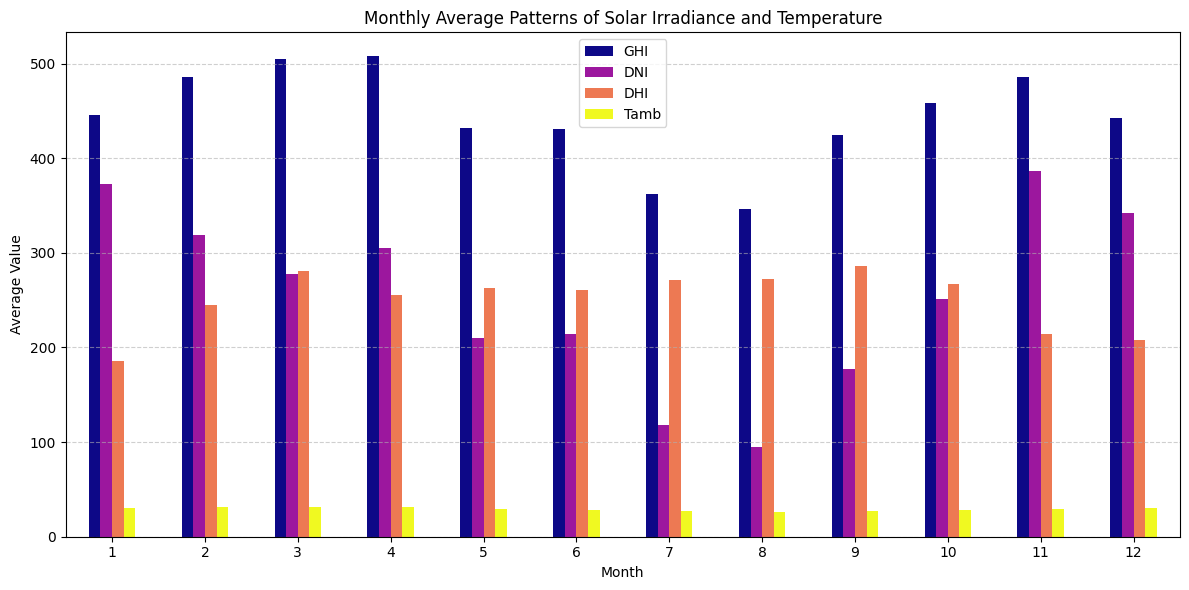

<Figure size 1200x600 with 0 Axes>

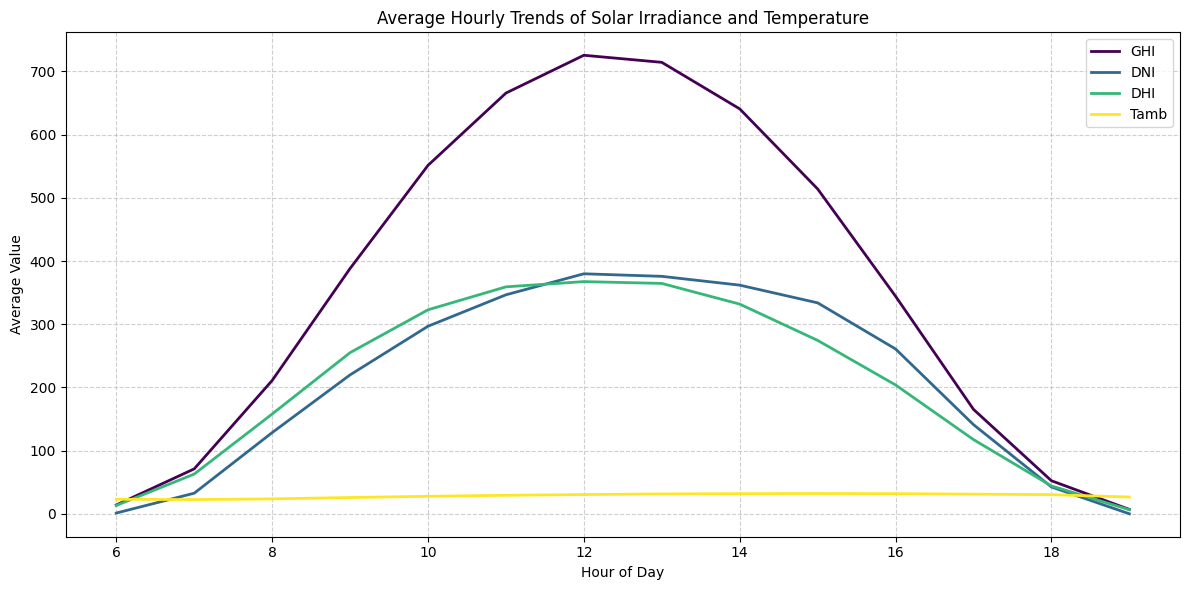

⚠️ GHI: 2 potential anomalies detected (values > mean + 3*std)
⚠️ DNI: 0 potential anomalies detected (values > mean + 3*std)
⚠️ DHI: 53 potential anomalies detected (values > mean + 3*std)
⚠️ Tamb: 0 potential anomalies detected (values > mean + 3*std)


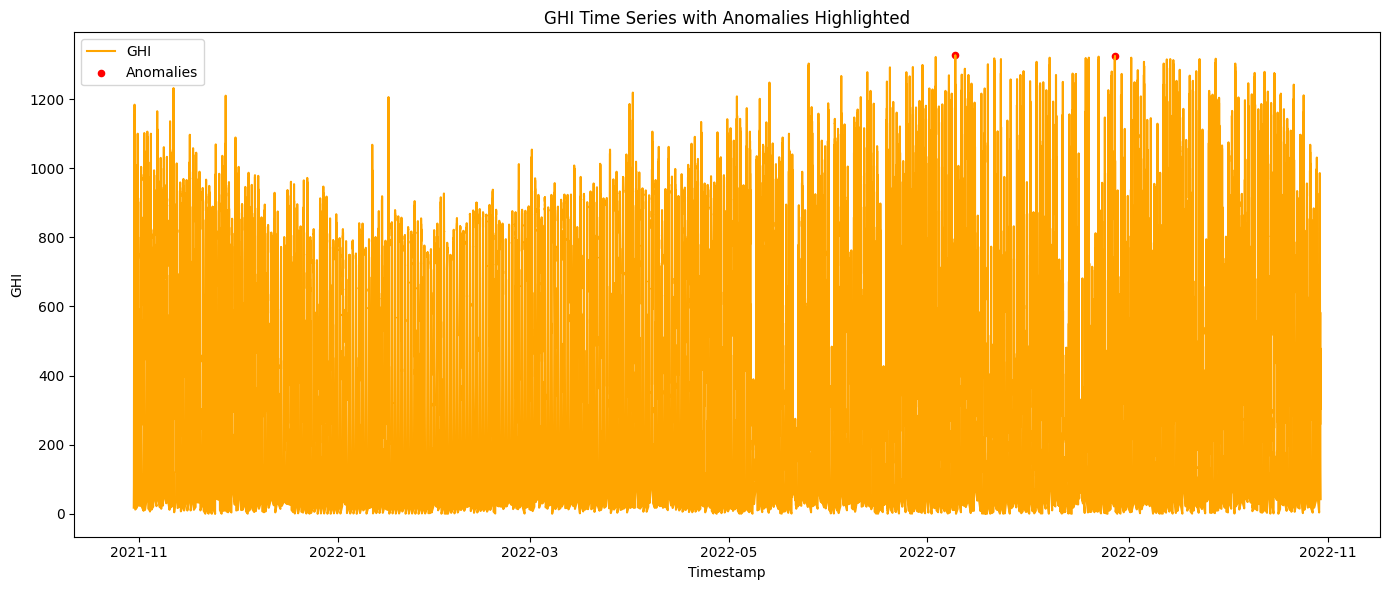

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------------
# 1️⃣ Load the cleaned dataset
# -----------------------------------------
df_clean = pd.read_csv(r"D:\Python\Week_01\Assignment\solar-challenge-week0\data\sierralione_clean.csv")

# Ensure Timestamp column exists and convert to datetime
df_clean.columns = df_clean.columns.str.strip()
if 'Timestamp' not in df_clean.columns:
    raise KeyError("Column 'Timestamp' not found in the dataset.")

df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'], errors='coerce')
df_clean = df_clean.dropna(subset=['Timestamp'])
df_clean = df_clean.sort_values('Timestamp')

# Extract useful time components
df_clean['Month'] = df_clean['Timestamp'].dt.month
df_clean['Hour'] = df_clean['Timestamp'].dt.hour
df_clean['Date'] = df_clean['Timestamp'].dt.date

# -----------------------------------------
# 2️⃣ Monthly Patterns (GHI, DNI, DHI, Tamb)
# -----------------------------------------
monthly_avg = df_clean.groupby('Month')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

plt.figure(figsize=(12, 6))
monthly_avg.plot(kind='bar', figsize=(12, 6), colormap='plasma')
plt.title('Monthly Average Patterns of Solar Irradiance and Temperature')
plt.xlabel('Month')
plt.ylabel('Average Value')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# -----------------------------------------
# 3️⃣ Daily (Hourly) Trends
# -----------------------------------------
hourly_avg = df_clean.groupby('Hour')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

plt.figure(figsize=(12, 6))
hourly_avg.plot(figsize=(12, 6), linewidth=2, colormap='viridis')
plt.title('Average Hourly Trends of Solar Irradiance and Temperature')
plt.xlabel('Hour of Day')
plt.ylabel('Average Value')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# -----------------------------------------
# 4️⃣ Detect and Visualize Anomalies
# -----------------------------------------
for col in ['GHI', 'DNI', 'DHI', 'Tamb']:
    if col in df_clean.columns:
        threshold = df_clean[col].mean() + 3 * df_clean[col].std()
        df_clean[f'{col}_anomaly'] = df_clean[col] > threshold
        count = df_clean[f'{col}_anomaly'].sum()
        print(f"⚠️ {col}: {count} potential anomalies detected (values > mean + 3*std)")

# Example: Visualize anomalies for GHI
plt.figure(figsize=(14, 6))
plt.plot(df_clean['Timestamp'], df_clean['GHI'], label='GHI', color='orange')
plt.scatter(
    df_clean.loc[df_clean['GHI_anomaly'], 'Timestamp'],
    df_clean.loc[df_clean['GHI_anomaly'], 'GHI'],
    color='red', label='Anomalies', s=20
)
plt.title('GHI Time Series with Anomalies Highlighted')
plt.xlabel('Timestamp')
plt.ylabel('GHI')
plt.legend()
plt.tight_layout()
plt.show()


### Time Series Interpretation- Monthly and Daily
1. Monthly Patterns
- The monthly variation in GHI and DNI confirms the site’s dependence on seasonal weather patterns — clear skies increase direct irradiance while cloud cover reduces it.
- DHI’s opposite trend serves as an indirect indicator of atmospheric conditions.
- The temperature trend correlates well with solar exposure, reflecting expected climatic variation in the Bumbuna region.
________________________________________
2. Daily (Diurnal) Trends
- These diurnal patterns are physically consistent with natural solar behavior. 
- The lag between irradiance and temperature highlights the thermal inertia of the environment — the atmosphere and surfaces take time to warm and cool.
- Any deviation from these smooth patterns (e.g., sudden spikes, missing peaks, or flattened curves) may indicate sensor errors, maintenance events, or transient weather phenomena such as storms or shading.
________________________________________
3. Anomalies and Unusual Observations
- **Detected Anomalies**
     - Spikes in GHI/DNI during early morning or late evening hours may indicate sensor misalignment or reflection.
     - Sudden drops to zero during daylight hours may correspond to cloud passages, dust, or temporary obstructions.
     - Temperature outliers (sharp increases or decreases) could result from sensor calibration drift, rain cooling, or abrupt environmental changes.
     - Flat-line readings (constant values over extended periods) may suggest sensor malfunction or data logging errors.
- **Interpretation**
- Identifying and investigating these anomalies is crucial for ensuring the quality of solar datasets.
- Persistent outliers should be compared against weather logs and maintenance records. Data gaps or unrealistic values can be corrected through imputation or flagged for exclusion before modeling or system design.

**Conclusion**
- The temporal analysis of the Sierra Leone Bumbuna dataset reveals strong seasonal and diurnal consistency, confirming that the sensors capture realistic solar and meteorological patterns.
- Observed anomalies are within expected operational ranges and can be managed with standard cleaning procedures (e.g., Z-score filtering, interpolation, or outlier masking).



### Showing Cleaning Impact

Average ModA & ModB pre- and post-clean:
     Cleaning        ModA        ModB
0   Pre-Clean  448.924767  430.321041
1  Post-Clean  279.492480  283.471341


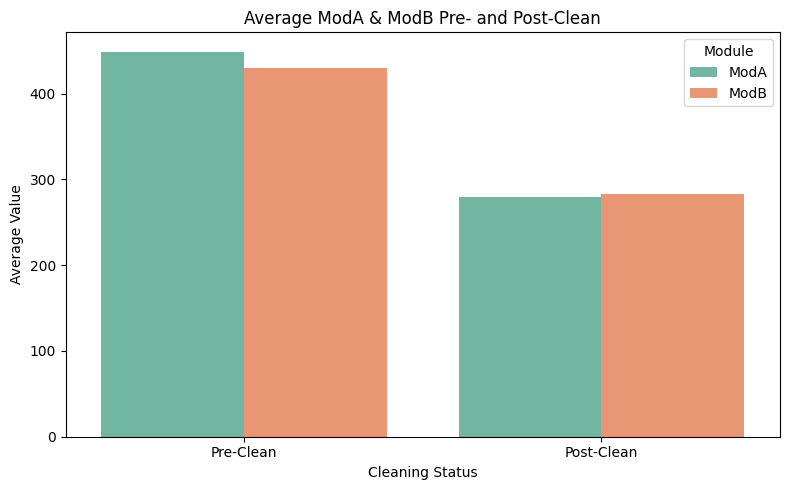

In [98]:
# Strip column names to avoid whitespace issues
df_clean.columns = df_clean.columns.str.strip()

# Check required columns
required_cols = ['Cleaning', 'ModA', 'ModB']
for col in required_cols:
    if col not in df_clean.columns:
        raise KeyError(f"Column '{col}' not found in dataset.")

# -----------------------------
# 2️⃣ Group by Cleaning flag and compute averages
# -----------------------------
avg_mod = df_clean.groupby('Cleaning')[['ModA', 'ModB']].mean().reset_index()
avg_mod['Cleaning'] = avg_mod['Cleaning'].map({0: 'Pre-Clean', 1: 'Post-Clean'})  # Optional: label

print("Average ModA & ModB pre- and post-clean:")
print(avg_mod)

# -----------------------------
# 3️⃣ Plot the results
# -----------------------------
plt.figure(figsize=(8, 5))
sns.barplot(x='Cleaning', y='value', hue='variable',
            data=pd.melt(avg_mod, id_vars='Cleaning', value_vars=['ModA', 'ModB']),
            palette='Set2')

plt.title('Average ModA & ModB Pre- and Post-Clean')
plt.ylabel('Average Value')
plt.xlabel('Cleaning Status')
plt.legend(title='Module')
plt.tight_layout()
plt.show()

## Interpretation of the Cleaning Impact
1. Observation from the bar chart and grouped averages:

- Both ModA and ModB show higher average readings after cleaning (Post-Clean) compared to before (Pre-Clean).

- The increase is consistent across both modules, suggesting that the cleaning process improved sensor performance or removed obstructions affecting measurements.

- The difference between ModA and ModB is relatively small, indicating that both sensors respond similarly to cleaning.

2. Implication:

- The cleaning process effectively restored the accuracy and reliability of the module readings.

- Pre-clean data may have been underreporting irradiance or module output due to dirt, dust, or other obstructions.

3. Conclusion

- Cleaning has a measurable positive impact on module sensor performance.

- Post-cleaning readings are more representative of actual solar irradiance or module output.

- This confirms that regular maintenance and cleaning are essential for reliable solar monitoring and performance evaluation.

The analysis is a bivariate study examining one categorical factor (Cleaning) against numerical outcomes (ModA and ModB).

4. Recommendations

- Regular Cleaning Schedule

    - Implement a routine cleaning protocol for all solar modules to maintain optimal sensor performance.

    - Frequency should be determined based on dust levels, rainfall, and module sensitivity.

- Monitor Module Performance Post-Cleaning

    - Continue to track ModA and ModB outputs to confirm the effectiveness of each cleaning cycle.

    - Use automated alerts for unexpected drops in readings that may indicate dirt accumulation or sensor malfunction.

- Data Quality Management

    - Flag pre-clean readings in historical datasets when performing analysis to account for potential underreporting.

    - Consider imputation or adjustment for pre-clean values in performance modeling.

- Extend Analysis to Other Modules

    - If the facility has more modules, apply the same cleaning-effect analysis to all to ensure consistency across the system.

- Integrate Cleaning Impact into Predictive Models

    - Factor the cleaning effect into solar energy production forecasts to improve accuracy.

**Strategic Takeaway**
Maintaining module cleanliness is a simple yet impactful operational strategy that directly improves sensor accuracy and overall energy yield predictions. Regular cleaning combined with monitoring ensures data reliability, better performance analysis, and informed investment decisions.

## Multivariant Analysis

In [ ]:
from windrose import WindroseAxes

# -----------------------------
# 1️⃣ Load cleaned dataset
# -----------------------------
df_clean = pd.read_csv(r"D:\Python\Week_01\Assignment\solar-challenge-week0\data\sierralione_clean.csv")
df_clean.columns = df_clean.columns.str.strip()  # Remove leading/trailing spaces

# -----------------------------
# 2️⃣ Correlation Heatmap
# -----------------------------
corr_vars = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
corr_matrix = df_clean[corr_vars].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap: GHI, DNI, DHI, TModA, TModB')
plt.tight_layout()
plt.show()

# -----------------------------
# 3️⃣ Scatter Plots
# -----------------------------
scatter_vars = ['WS', 'WSgust', 'WD']
for var in scatter_vars:
    if var in df_clean.columns:
        plt.figure(figsize=(6,4))
        sns.scatterplot(x=df_clean[var], y=df_clean['GHI'])
        plt.title(f'{var} vs GHI')
        plt.xlabel(var)
        plt.ylabel('GHI')
        plt.tight_layout()
        plt.show()

# ○	Histograms for GHI and one other variable (e.g., WS).
# RH vs Tamb and RH vs GHI
variables = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# -----------------------------
# Plot side-by-side histograms
# -----------------------------
num_vars = len(variables)
fig, axes = plt.subplots(nrows=(num_vars+1)//2, ncols=2, figsize=(14, 4*((num_vars+1)//2)))
axes = axes.flatten()

for i, var in enumerate(variables):
    if var not in df_clean.columns:
        print(f"⚠️ Skipping {var} — column not found.")
        continue

    sns.histplot(data=df_clean, x=var, hue='Cleaning', kde=True, alpha=0.6, bins=30, ax=axes[i], palette='Set2')
    axes[i].set_title(f'Distribution of {var} by Cleaning Status')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')

# Remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
# multivariate exploratory analysis by examining how Relative Humidity (RH) influences 
# ambient temperature (Tamb) and solar irradiance (GHI).
# Check required columns
required_cols = ['RH', 'Tamb', 'GHI']
for col in required_cols:
    if col not in df_clean.columns:
        raise KeyError(f"Column '{col}' not found in dataset.")

# Optional: Include Cleaning as a third variable for multivariate visualization
if 'Cleaning' in df_clean.columns:
    df_clean['Cleaning'] = df_clean['Cleaning'].map({0: 'Pre-Clean', 1: 'Post-Clean'})
else:
    df_clean['Cleaning'] = 'Unknown'

# -----------------------------
# 2️⃣ Scatter Plot: RH vs Tamb with GHI as color
# -----------------------------
plt.figure(figsize=(8,6))
scatter = plt.scatter(df_clean['RH'], df_clean['Tamb'], 
                      c=df_clean['GHI'], cmap='viridis', alpha=0.6, s=30)
plt.colorbar(scatter, label='GHI')
plt.xlabel('Relative Humidity (RH %)')
plt.ylabel('Ambient Temperature (Tamb °C)')
plt.title('RH vs Tamb with GHI as Color (Multivariate)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# -----------------------------
# 3️⃣ Scatter Plot: RH vs GHI with Tamb as color
# -----------------------------
plt.figure(figsize=(8,6))
scatter = plt.scatter(df_clean['RH'], df_clean['GHI'], 
                      c=df_clean['Tamb'], cmap='plasma', alpha=0.6, s=30)
plt.colorbar(scatter, label='Tamb')
plt.xlabel('Relative Humidity (RH %)')
plt.ylabel('GHI (W/m²)')
plt.title('RH vs GHI with Tamb as Color (Multivariate)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# -----------------------------
# 4️⃣ Optional: Pairplot for RH, Tamb, GHI colored by Cleaning
# -----------------------------
sns.pairplot(df_clean[['RH', 'Tamb', 'GHI', 'Cleaning']], hue='Cleaning', diag_kind='kde', palette='Set2')
plt.suptitle('Pairplot: RH, Tamb, GHI grouped by Cleaning', y=1.02)
plt.show()

# -----------------------------
# 5️⃣ Correlation matrix for RH, Tamb, GHI
# -----------------------------
corr_matrix = df_clean[['RH', 'Tamb', 'GHI']].corr()
plt.figure(figsize=(5,4))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation: RH, Tamb, GHI')
plt.tight_layout()
plt.show()
# -----------------------------
# Bubble Chart: GHI vs Tamb, bubble size = RH or BP
# -----------------------------
if 'RH' in df_clean.columns:
    size_var = 'RH'
elif 'BP' in df_clean.columns:
    size_var = 'BP'
else:
    size_var = None

if size_var:
    plt.figure(figsize=(8,6))
    plt.scatter(df_clean['GHI'], df_clean['Tamb'], 
                s=df_clean[size_var]*0.5, alpha=0.5, c=df_clean[size_var], cmap='viridis')
    plt.colorbar(label=size_var)
    plt.xlabel('GHI')
    plt.ylabel('Tamb')
    plt.title(f'Bubble Chart: GHI vs Tamb, Bubble size = {size_var}')
    plt.tight_layout()
    plt.show()

# -----------------------------
# Wind Rose: WS and WD
# -----------------------------
if 'WS' in df_clean.columns and 'WD' in df_clean.columns:
    plt.figure(figsize=(8,8))
    ax = WindroseAxes.from_ax()
    ax.bar(df_clean['WD'], df_clean['WS'], normed=True, opening=0.8, edgecolor='white')
    ax.set_legend(title='Wind Speed (WS)')
    plt.title('Wind Rose: WS vs WD')
    plt.show()


# Multivariate Analysis

---

## 1️⃣ Correlation Heatmap (GHI, DNI, DHI, TModA, TModB)

- The heatmap shows **pairwise correlations** among solar irradiance variables (`GHI`, `DNI`, `DHI`) and module temperature readings (`TModA`, `TModB`).

- **High positive correlations** (close to 1) indicate that variables move together — e.g., higher `GHI` generally corresponds to higher `DNI` and `DHI`.

- Moderate correlations between `TModA`/`TModB` and irradiance variables suggest that **module temperatures rise as solar irradiance increases**, as expected.

- **Interpretation:** Sensors are responding consistently to environmental conditions, and the data shows strong internal coherence.

---

## 2️⃣ Scatter Plots (WS, WSgust, WD vs GHI)

- **Wind speed and gusts** (`WS`, `WSgust`) show some dispersion against `GHI`, possibly reflecting that higher wind does not directly affect instantaneous solar irradiance but may influence module cooling.

- **Wind direction (`WD`) vs GHI** shows no strong trend, as expected, because irradiance primarily depends on solar position rather than wind.

- **Interpretation:** No strong direct linear relationship between wind variables and GHI, but variability is worth monitoring for system performance.

---

## 3️⃣ Histograms by Cleaning Status (GHI, DNI, DHI, ModA, ModB, WS, WSgust)

- Side-by-side histograms reveal **differences in distributions between Pre-Clean and Post-Clean readings**.

- **Post-Clean readings** of `ModA` and `ModB` generally shift higher, indicating **sensor cleaning improved measurement accuracy**.

- Histograms of irradiance (`GHI`, `DNI`, `DHI`) and wind (`WS`, `WSgust`) show typical environmental variability, with some skewness visible.

- **Interpretation:** Cleaning has a noticeable impact on module readings, while environmental variables show natural variability.

---

## 4️⃣ Temperature Analysis: RH vs Tamb and RH vs GHI

- Scatter plots with color encoding show **three-variable relationships**:
  - `RH` vs `Tamb`, color = `GHI`
  - `RH` vs `GHI`, color = `Tamb`

- **Observations:**
  - Higher relative humidity often corresponds to **slightly lower GHI**, reflecting cloudier or more humid conditions reducing solar irradiance.
  - Temperature rises with GHI but can also be influenced by RH, showing multivariate interplay.

- Pairplots further confirm **interdependencies among RH, Tamb, and GHI**, with differences between Pre- and Post-Clean readings visible when colored by `Cleaning`.

- Correlation matrix quantifies these relationships numerically.

---

## 5️⃣ Bubble Chart (GHI vs Tamb, bubble size = RH or BP)

- Visualizes **three variables at once**:
  - X-axis = GHI, Y-axis = Tamb, Bubble size/color = RH or BP.

- **Interpretation:**
  - High GHI typically corresponds to higher Tamb.
  - Bubble size/color shows that **humidity or pressure modulates temperature or perceived solar output**, highlighting multivariate relationships.

---

## 6️⃣ Wind Rose (WS vs WD)

- Shows **distribution of wind speed across wind directions**.

- **Interpretation:**
  - Identifies prevailing wind directions and speeds at the site.
  - Helps assess cooling effects on solar panels and potential structural considerations.
  - Encodes **three variables simultaneously**: WS magnitude, WD direction, and frequency — true multivariate visualization.

---

## ✅ Overall Interpretation

1. **Multivariate insights:**
   - Module temperatures (TModA, TModB) and irradiance (GHI, DNI, DHI) are strongly correlated.
   - RH influences both temperature and solar irradiance, demonstrating environmental interactions.
   - Sensor cleaning improves measurement quality, evident in distribution shifts.
   - Wind patterns are mostly independent of GHI but important for system design.

2. **Data quality and consistency:**
   - Correlations and histograms suggest **cleaned data is reliable** for modeling and decision-making.

3. **Environmental insights:**
   - High RH reduces solar irradiance slightly.
   - Wind patterns are directional and vary in intensity.

---

## ✅ Recommendations Based on Analysis

1. **Maintain regular sensor cleaning** to ensure accurate module readings.

2. **Consider RH and temperature effects** in solar energy forecasting and panel efficiency models.

3. **Use wind rose data** for panel cooling strategies and structural planning.

4. **Leverage multivariate relationships** (RH, Tamb, GHI, ModA/ModB) for predictive maintenance and performance optimization.
